In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pid_model as pidmodel
import pid_performances as pidper

## Requirements

In [17]:
from moonlight import *

script_oscillation = """
signal {real x;}
domain minmax;
formula oscillation = globally [20.0, 300.0] (x < 0.05);
"""

script_distanceref = """
signal {real d;}
domain minmax;
formula distance = globally [10.0, 300.0] (d < 0.05);
"""

script_speed = """
signal {real v;}
domain minmax;
formula speed = globally (v < 130);
"""
script_acceleration = """
signal { real x; real y; real u;}
domain minmax; 
formula positive_delta = globally ((x <= y) -> (u >= 0));
formula negative_delta = globally ((x > y) -> (u < 0));
"""



moonlightScript_oscillation = ScriptLoader.loadFromText(script_oscillation)
monitor_1 = moonlightScript_oscillation.getMonitor("oscillation")
moonlightScript_distanceref = ScriptLoader.loadFromText(script_distanceref)
monitor_2 = moonlightScript_distanceref.getMonitor("distance")
moonlightScript_speed = ScriptLoader.loadFromText(script_speed)
monitor_3 = moonlightScript_speed.getMonitor("speed")
moonlightScript_acceleration = ScriptLoader.loadFromText(script_acceleration)
monitor_4 = moonlightScript_acceleration.getMonitor("positive_delta")
monitor_5 = moonlightScript_acceleration.getMonitor("negative_delta")

## Pid controller with $\theta_{ref} = 0.785$ (45°)

overshoot: 0.015
rise time: 3.0
steady state error: 0.0
settling time: 18.0


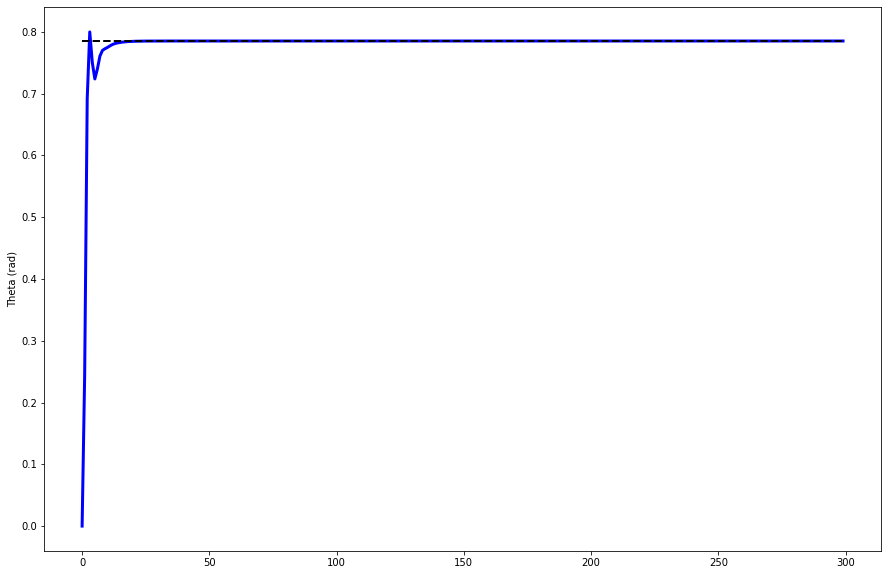

In [23]:
sp = np.zeros(300) + 0.785
theta_store, omega_store, sp_store, v_store, u_store, ts = pidmodel.run(299, 300, sp, [0.0,0.0], False, 15,30,20)
pidper.print_performances(theta_store, sp_store, ts)
pidmodel.plot(theta_store, omega_store, sp_store, v_store,u_store, ts)

## Pid controller with $\theta_{ref} = 0.262 (15°)$

overshoot: 0.048
rise time: 3.0
steady state error: 0.0
settling time: 12.0


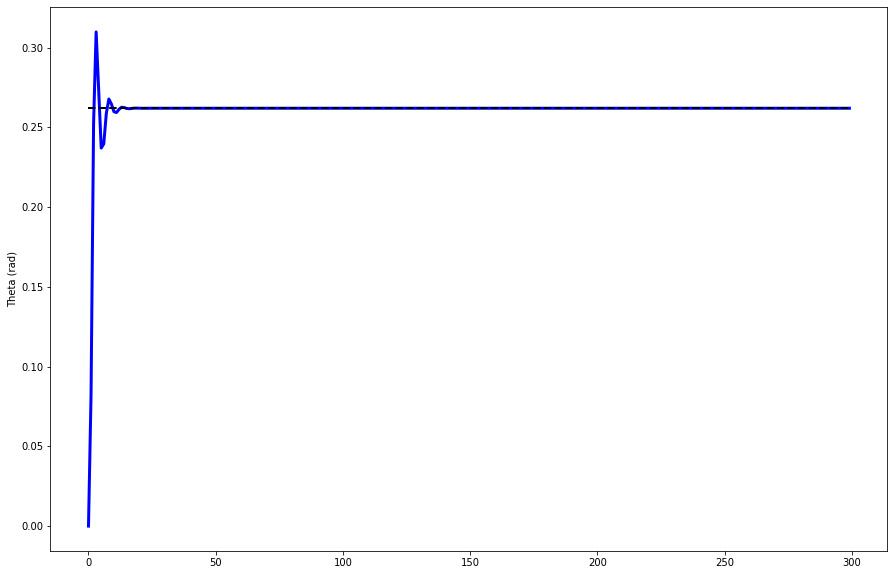

In [24]:
sp = np.zeros(300) + 0.262
theta_store, omega_store, sp_store, v_store, u_store, ts = pidmodel.run(299, 300, sp, [0.0,0.0], False, 15,30,20)
pidper.print_performances(theta_store, sp_store, ts)
pidmodel.plot(theta_store, omega_store, sp_store, v_store,u_store, ts)

- Unifica "simulazione-monitoring"
- noise più o meno piccini
- varia parametri input

## Pid controller with sinusoidal reference signal

In [9]:
sp = [np.sin(i/20)/10 + 0.2 for i in range(300)]
theta_store, omega_store, sp_store, v_store,u_store, ts = pidmodel.run(299, 300, sp, [0.0,0.0], False, 15,30,30)

In [10]:
print(f'overshoot: {pidper.overshoot(theta_store, sp_store)}')
print(f'rise time: {pidper.rise_time(theta_store, sp_store, ts)}')
print(f'steady state error: {pidper.steady_state_error(theta_store, sp_store)}')
print(f'settling time: {pidper.settling_time(theta_store, ts)}')

overshoot: 0.0
rise time: 3.0
steady state error: 0.006
settling time: 270.0


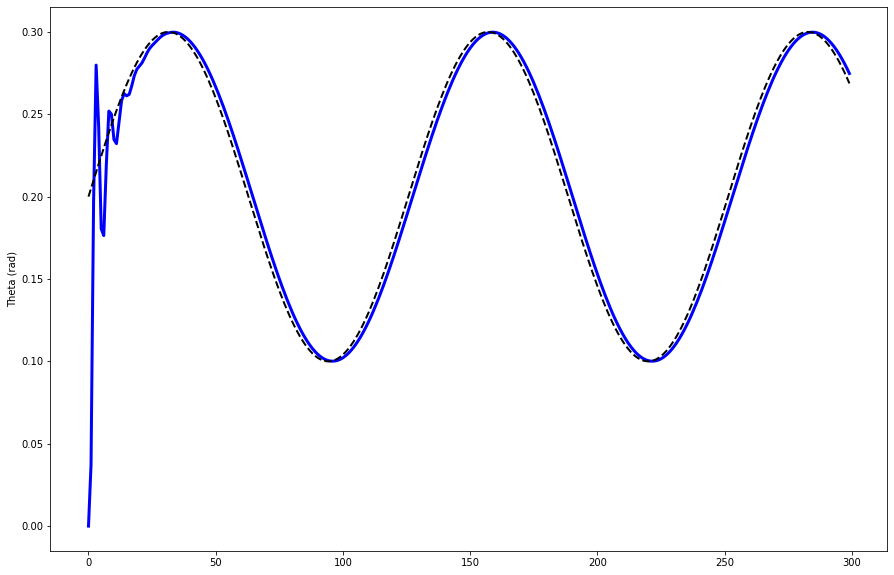

In [11]:
pidmodel.plot(theta_store, omega_store, sp_store, v_store,step, ts)

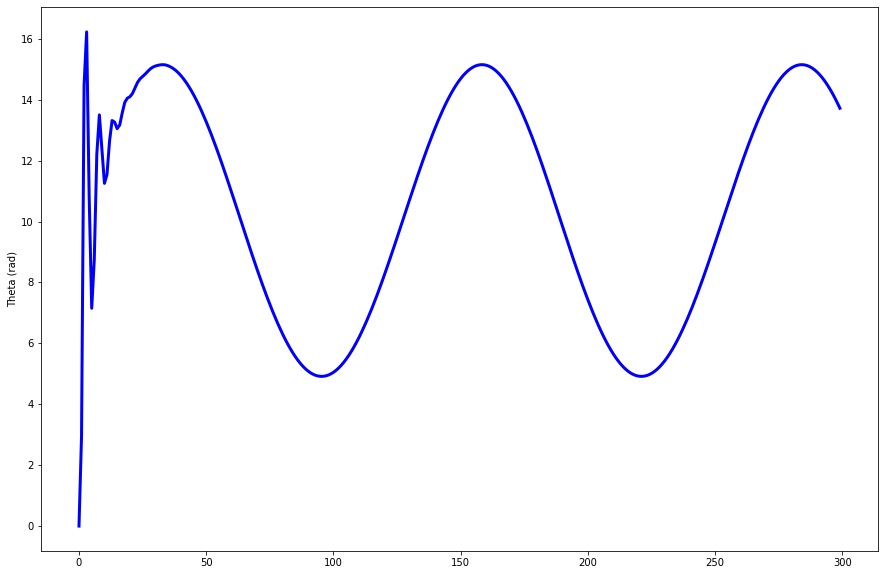

In [12]:
plt.plot(ts,u_store,'b-',linewidth=3)
plt.ylabel('Theta (rad)')
plt.show()

## Requirements in STL with Moonlight

In [25]:
from moonlight import *

script_oscillation = """
signal {real x;}
domain minmax;
formula oscillation = globally [20.0, 300.0] (x < 0.05);
"""

script_distanceref = """
signal {real d;}
domain minmax;
formula distance = globally [10.0, 300.0] (d < 0.05);
"""

script_speed = """
signal {real v;}
domain minmax;
formula speed = globally (v < 130);
"""
script_acceleration = """
signal { real x; real y; real u;}
domain minmax; 
formula positive_delta = globally ((x <= y) -> (u >= 0));
formula negative_delta = globally ((x > y) -> (u < 0));
"""



moonlightScript_oscillation = ScriptLoader.loadFromText(script_oscillation)
monitor_1 = moonlightScript_oscillation.getMonitor("oscillation")
moonlightScript_distanceref = ScriptLoader.loadFromText(script_distanceref)
monitor_2 = moonlightScript_distanceref.getMonitor("distance")
moonlightScript_speed = ScriptLoader.loadFromText(script_speed)
monitor_3 = moonlightScript_speed.getMonitor("speed")
moonlightScript_acceleration = ScriptLoader.loadFromText(script_acceleration)
monitor_4 = moonlightScript_acceleration.getMonitor("positive_delta")
monitor_5 = moonlightScript_acceleration.getMonitor("negative_delta")

[[0.         0.04993177]]


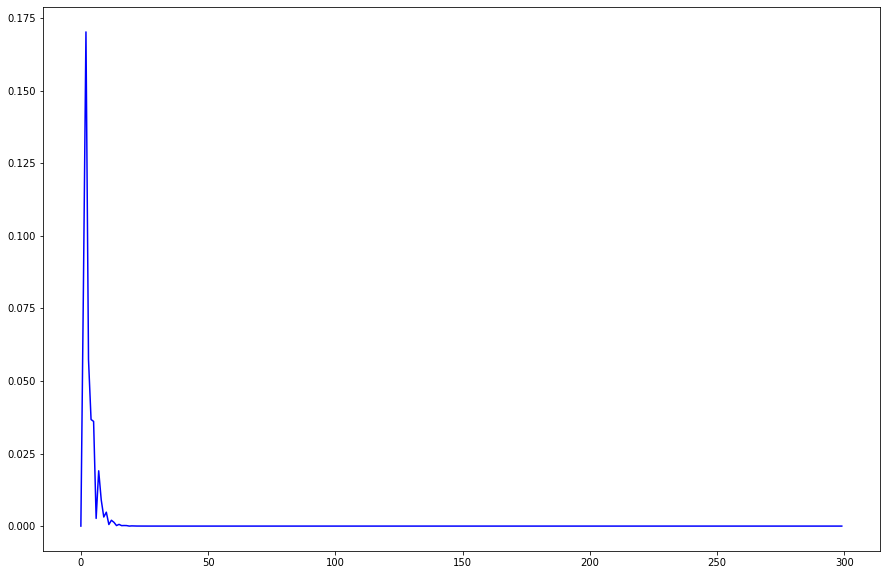

In [26]:
osc = np.zeros(300)
for i in range(1, len(osc)):
    osc[i] = np.abs(theta_store[i] - theta_store[i-1])

ts_temp = list(ts)
signals = list(zip(osc))
result = monitor_1.monitor(ts_temp,signals)
arrayresults = np.array(monitor_1.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,osc, color="blue")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

[[0.         0.04731506]]


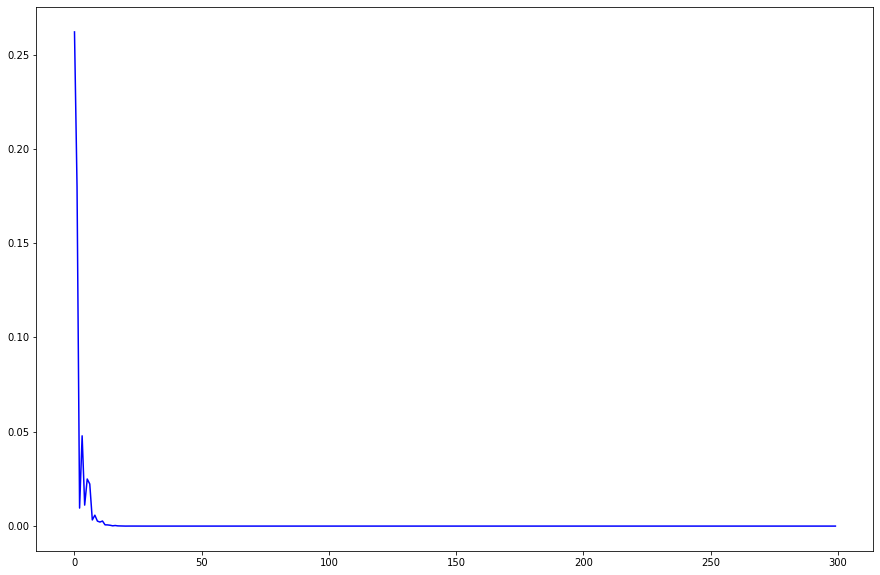

In [27]:
dist = np.abs(theta_store - sp_store)

ts_temp = list(ts)
signals = list(zip(dist))
result = monitor_2.monitor(ts_temp,signals)
arrayresults = np.array(monitor_2.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,dist, color="blue")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

[[  0.          87.71807167]
 [231.          87.71807167]
 [297.          87.71807167]
 [298.          87.71807167]
 [299.          87.71807167]]


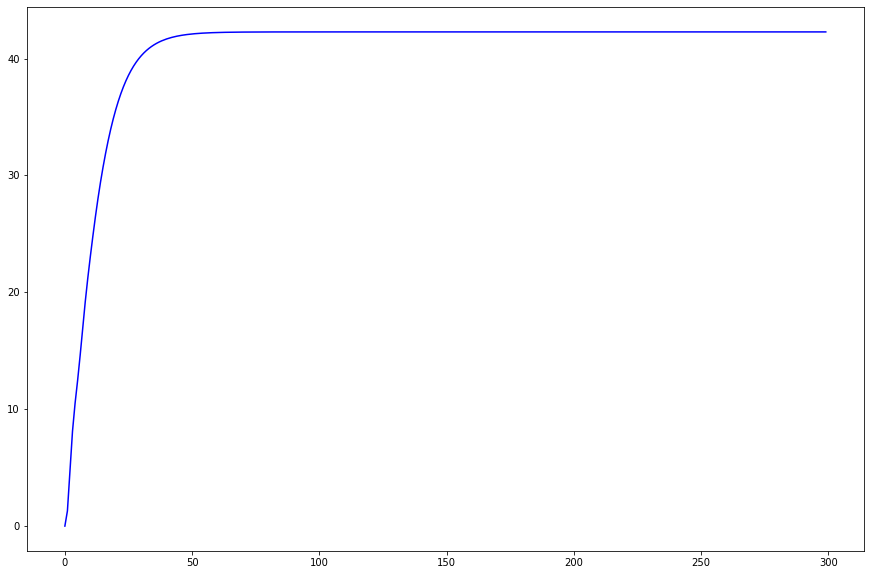

In [31]:
ts_temp = list(ts)
signals = list(zip(v_store))
result = monitor_3.monitor(ts_temp,signals)
arrayresults = np.array(monitor_3.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,v_store, color="blue")
print(arrayresults)

[[ 0.00000000e+00 -9.54866059e-03]
 [ 3.00000000e+00  0.00000000e+00]
 [ 2.99000000e+02  0.00000000e+00]]


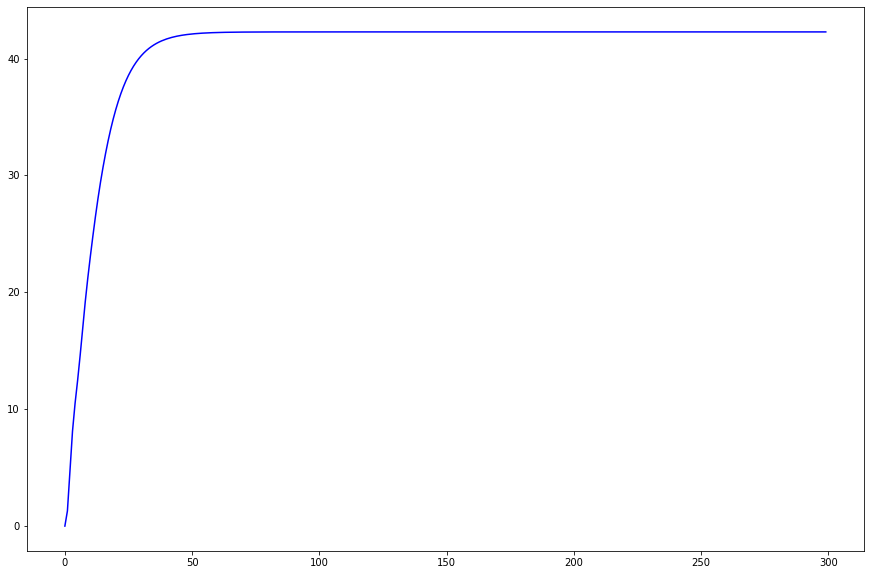

In [29]:
diff_u = np.zeros(len(u_store))
for i in range(1, len(u_store)):
    diff_u[i] = u_store[i] - u_store[i-1]
    if i == 10:
        break


ts_temp = list(ts)
signals = list(zip(theta_store, sp_store, diff_u))
result = monitor_4.monitor(ts_temp,signals)
arrayresults = np.array(monitor_4.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,v_store, color="blue")
print(arrayresults)

[[0.00000000e+00 0.00000000e+00]
 [2.98000000e+02 2.02728945e-11]
 [2.99000000e+02 3.09668402e-11]]


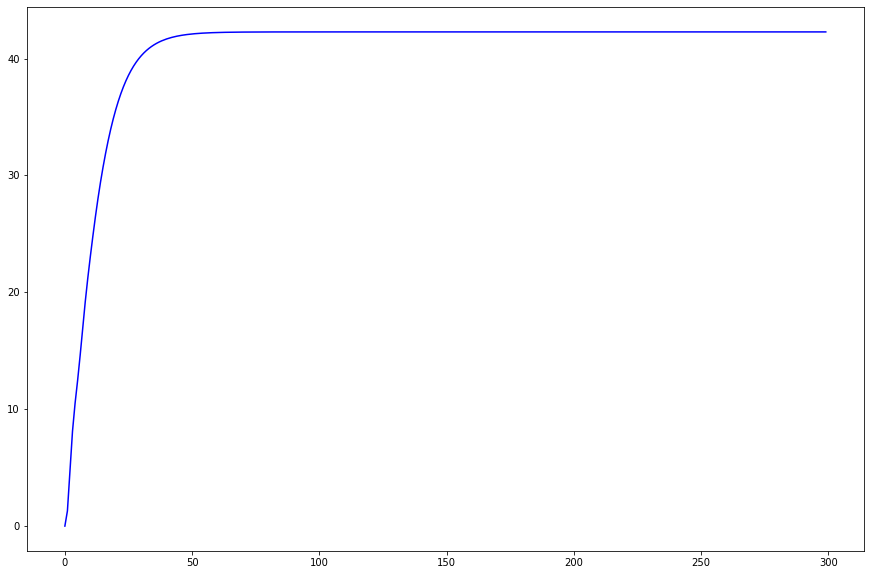

In [30]:
ts_temp = list(ts)
signals = list(zip(theta_store, sp_store, diff_u))
result = monitor_5.monitor(ts_temp,signals)
arrayresults = np.array(monitor_5.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,v_store, color="blue")
print(arrayresults)

In [13]:
mi, sigma = 0.0,.1
n = np.random.normal(mi,sigma, 100)

# L'idea è che aggiungo questo rumore all'osservazione dei sensori e controllo la robustness con o senza rumore
# RICORDA: formula verificata -> robustness > 0 